In [21]:
import pickle
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.metrics import roc_curve, auc
from timeit import default_timer as timer

import pickle
from sklearn.preprocessing import LabelBinarizer

# these libraries are rwuired to plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
current_palette = sns.color_palette()



In [22]:
# Tensorflow version 0.12.0/0.12.1 is required as there are issues working with versions aboove for the neural network models
tf.__version__

'0.12.1'

In [23]:
def getvalue(item):
    fpr, tpr, _ = roc_curve(test_labels.ravel(), test_preds[item])
    roc_auc = auc(fpr, tpr)
    return roc_auc

def plotROC(testlabels, test_preds):
    classifiers = list(test_preds.keys())

    # Plot all ROC curves
    plt.figure(figsize=(15,9))
    for i, clf in zip(range(len(classifiers)), sorted(classifiers, key=getvalue, reverse=True)):
        fpr, tpr, _ = roc_curve(testlabels.ravel(), test_preds[clf] )
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr,
                 label='ROC curve '+ clf +  ' (area = {0:0.4f})'
                       ''.format(roc_auc), linestyle='-', linewidth=2)


    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.1, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False +Rate')
    plt.ylabel('True +Rate')
    plt.title('Comparison of the multiclass ROC curves')
    plt.legend(loc="lower right", fontsize=14)
    plt.show()

In [24]:
data = pickle.load(open('feature_data1.p', 'rb'))


In [25]:
print(data.columns)
print(data.shape)

Index(['shape', 'label', 'fold', 'children', 'car_horn', 'street_m',
       'engine_i', 'air_cond', 'drilling', 'gun_shot', 'siren', 'dog_bark',
       'jackhamm', 'sample'],
      dtype='object')
(8731, 14)


In [26]:
s = list(data['sample'])
s = pd.DataFrame(s)
data_cols = s.columns
s['label'] = data['label']
print('working dataframe\'s shape:', s.shape)

working dataframe's shape: (8731, 194)


In [27]:
test_preds = {}
train = s[0:6984]
test = s[6984:]
LB = LabelBinarizer().fit(train['label'])
test_labels = LB.transform(test['label'])
scaler1 = sk.preprocessing.StandardScaler().fit(train.loc[:,data_cols])
train.loc[:,data_cols] = scaler1.transform(train.loc[:,data_cols])
test.loc[:,data_cols] = scaler1.transform(test.loc[:,data_cols])

# truncate data
#data_cols = data_cols[:1000]

# print shapes
print('train shape {}\ntest  shape {}\ncommon factors: 1, 2, 3, 6, 9, 18, 97, 194, 291, 582, 873, 1746'.format(train.shape, test.shape))

/Users/kasiemobimaduabunachukwu/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


train shape (6984, 194)
test  shape (1747, 194)
common factors: 1, 2, 3, 6, 9, 18, 97, 194, 291, 582, 873, 1746


In [28]:
del data, s

In [29]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def test_accuracy(session, test_data=test, during = True):
    test_data.reset_index(inplace=True, drop=True)
    epoch_pred = session.run(test_prediction, feed_dict={tf_data : test_data.loc[0:check_size-1,data_cols], keep_prob : 1.0})
    for i in range(check_size, test_data.shape[0], check_size):
        epoch_pred = np.concatenate([epoch_pred, session.run(test_prediction, 
                                    feed_dict={tf_data : test_data.loc[i:i+check_size-1,data_cols], keep_prob : 1.0})], axis=0)
    if during:
        return accuracy(epoch_pred, test_labels)
    else:
        return epoch_pred

## Run Session

In [30]:
num_labels = 10
batch_size = 97
acc_over_time = {}
def Run_Session(num_epochs, name, k_prob=1.0, mute=False, record=False):
    global train
    
    start = timer()
    with tf.Session(graph=graph) as session:
        if record:
            merged = tf.merge_all_summaries()  
            writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        #tf.initialize_all_variables().run()
        tf.global_variables_initializer().run()

        print("Initialized")
        accu = []
        
        for epoch in range(num_epochs):
            
            # get batch
            train_batch = train.sample(batch_size)
            
            t_d = train_batch[data_cols]
            t_l = LB.transform(train_batch['label'])
            
            # make feed dict
            feed_dict = { tf_data : t_d, train_labels : t_l, keep_prob : k_prob}
            
            # run model on batch
            _, l, predictions = session.run([optimizer, loss, prediction], feed_dict=feed_dict)
            
            # mid model accuracy checks 
            if (epoch % 1000 == 0) and not mute:
                print("\tMinibatch loss at epoch {}: {}".format(epoch, l))
                print("\tMinibatch accuracy: {:.1f}".format(accuracy(predictions, t_l)))
            if (epoch % 1000 == 0) and not mute:
                print("Test accuracy: {:.1f}".format(test_accuracy(session, during=True)))
            if (epoch % 1000 == 0) and not mute:
                accu.append(tuple([epoch, test_accuracy(session, during=True)]))
                
        # record accuracy and predictions
        test_preds[name] = test_accuracy(session, during=False)
        print("Final Test accuracy: {:.1f}".format(accuracy(test_preds[name], test_labels)))
        end = timer()
        test_preds[name] = test_preds[name].ravel()
        acc_over_time[name] = accu
        print("time taken: {0} minutes {1:.1f} seconds".format((end - start)//60, (end - start)%60))
        #tf.train.export_meta_graph()

# DeepNN 
# some of the methods  were  heavily influenced by https://github.com/karoldvl/paper-2015-esc-convnet


In [31]:
# constants
num_labels = 10

batch_size = 97
check_size = 582
feature_size = 193

n_hidden1 = 800
n_hidden2 = 1000
n_hidden3 = 800

beta = 0.01

graph = tf.Graph()
with graph.as_default():
    # placeholders
    tf_data = tf.placeholder(tf.float32, shape=[None, feature_size])
    train_labels = tf.placeholder(tf.float32, shape=[None, num_labels])
    keep_prob = tf.placeholder(tf.float32)
    
    # weights and biases
    layer1_weights = weight_variable([feature_size, n_hidden1])
    layer1_biases = bias_variable([n_hidden1])
    layer2_weights = weight_variable([n_hidden1, n_hidden2])
    layer2_biases = bias_variable([n_hidden2])
    layer3_weights = weight_variable([n_hidden2, n_hidden3])
    layer3_biases = bias_variable([n_hidden3])
    layer4_weights = weight_variable([n_hidden3, num_labels])
    layer4_biases = bias_variable([num_labels])

    # model
    def model(data, proba=1.0):
        layer1 = tf.nn.relu(tf.matmul(data, layer1_weights) + layer1_biases)
        layer1 = tf.nn.dropout(layer1, proba)
        
        layer2 = tf.nn.relu(tf.matmul(layer1, layer2_weights) + layer2_biases)
        layer2 = tf.nn.dropout(layer2, proba)
        
        layer3 = tf.nn.relu(tf.matmul(layer2, layer3_weights) + layer3_biases)
        layer3 = tf.nn.dropout(layer3, proba)
        
        return tf.matmul(layer3, layer4_weights) + layer4_biases

    # Training computation.
    logits = model(tf_data, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, train_labels) +
                         beta*tf.nn.l2_loss(layer1_weights) +
                         beta*tf.nn.l2_loss(layer1_biases) +
                         beta*tf.nn.l2_loss(layer2_weights) +
                         beta*tf.nn.l2_loss(layer2_biases) +
                         beta*tf.nn.l2_loss(layer3_weights) +
                         beta*tf.nn.l2_loss(layer3_biases) +
                         beta*tf.nn.l2_loss(layer4_weights) +
                         beta*tf.nn.l2_loss(layer4_biases))

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(model(tf_data, proba=1.0))  
    print('Basic DeepNN model made')

Basic DeepNN model made


In [32]:
Run_Session(20000, 'DeepNN', .8)

Initialized
	Minibatch loss at epoch 0: 3.1146554946899414
	Minibatch accuracy: 10.3
Test accuracy: 11.7
	Minibatch loss at epoch 1000: 1.239444613456726
	Minibatch accuracy: 68.0
Test accuracy: 57.0
	Minibatch loss at epoch 2000: 0.7773647308349609
	Minibatch accuracy: 91.8
Test accuracy: 60.0
	Minibatch loss at epoch 3000: 0.7076855897903442
	Minibatch accuracy: 93.8
Test accuracy: 61.6
	Minibatch loss at epoch 4000: 0.7721562385559082
	Minibatch accuracy: 90.7
Test accuracy: 63.6
	Minibatch loss at epoch 5000: 0.688784122467041
	Minibatch accuracy: 94.8
Test accuracy: 62.6
	Minibatch loss at epoch 6000: 0.6390138864517212
	Minibatch accuracy: 95.9
Test accuracy: 64.3
	Minibatch loss at epoch 7000: 0.6980799436569214
	Minibatch accuracy: 95.9
Test accuracy: 63.3
	Minibatch loss at epoch 8000: 0.7097768783569336
	Minibatch accuracy: 93.8
Test accuracy: 62.9
	Minibatch loss at epoch 9000: 0.7144794464111328
	Minibatch accuracy: 96.9
Test accuracy: 63.7
	Minibatch loss at epoch 10000: 0

## CNN
## some of the methods were  deeply influenced  https://tspace.library.utoronto.ca/bitstream/1807/44123/1/Mohamed_Abdel-rahman_201406_PhD_thesis.pdf
Also heavily influenced by https://github.com/jaron/deep-listening


In [33]:
-

Basic CNN model made


In [34]:
Run_Session(20000, 'CNN', .5)

Initialized
	Minibatch loss at epoch 0: 4.888813495635986
	Minibatch accuracy: 7.2
Test accuracy: 11.8
	Minibatch loss at epoch 1000: 1.1624761819839478
	Minibatch accuracy: 71.1
Test accuracy: 65.0
	Minibatch loss at epoch 2000: 0.8388988971710205
	Minibatch accuracy: 81.4
Test accuracy: 69.9
	Minibatch loss at epoch 3000: 0.7024408578872681
	Minibatch accuracy: 89.7
Test accuracy: 69.5
	Minibatch loss at epoch 4000: 0.7634811997413635
	Minibatch accuracy: 87.6
Test accuracy: 70.9
	Minibatch loss at epoch 5000: 0.6441908478736877
	Minibatch accuracy: 92.8
Test accuracy: 69.8
	Minibatch loss at epoch 6000: 0.6266380548477173
	Minibatch accuracy: 93.8
Test accuracy: 69.4
	Minibatch loss at epoch 7000: 0.626704752445221
	Minibatch accuracy: 91.8
Test accuracy: 71.8
	Minibatch loss at epoch 8000: 0.6699497103691101
	Minibatch accuracy: 92.8
Test accuracy: 70.6
	Minibatch loss at epoch 9000: 0.6166098117828369
	Minibatch accuracy: 94.8
Test accuracy: 70.8
	Minibatch loss at epoch 10000: 0.

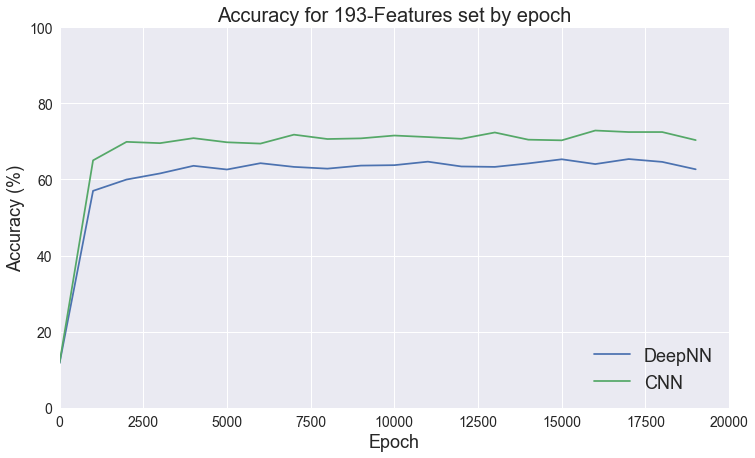

In [35]:
fig = plt.figure(figsize=[12,7])
plt.title('Accuracy for 193-Features set by epoch', fontsize=20)
plt.plot(np.array(acc_over_time['DeepNN'])[:,0], np.array(acc_over_time['DeepNN'])[:,1], label='DeepNN')
plt.plot(np.array(acc_over_time['CNN'])[:,0], np.array(acc_over_time['CNN'])[:,1], label='CNN')
plt.xlabel('Epoch', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=18)
plt.ylim([0, 100])
plt.xlim([0, 20000])
plt.legend(loc="lower right", fontsize=18)
plt.show()

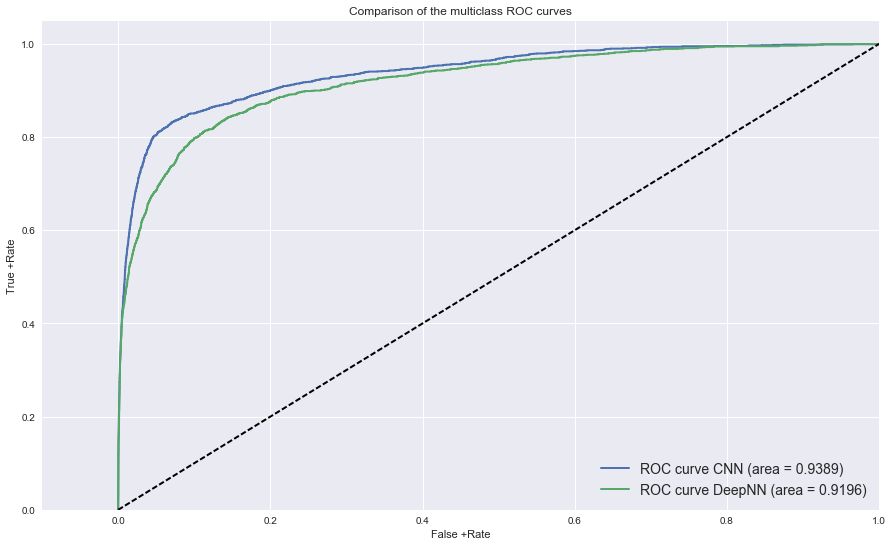

In [36]:
plotROC(test_labels, test_preds)

In [37]:
# numeralize labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
test_batch = le.fit_transform(test['label'])


def confusion(true, predicted):
    matrix = np.zeros([10,10])
    pred = predicted.reshape((predicted.shape[0]//10, 10))

    count = 0
    for lab in test_batch:
        matrix[lab] += pred[count].round()
        count += 1
        
    return matrix

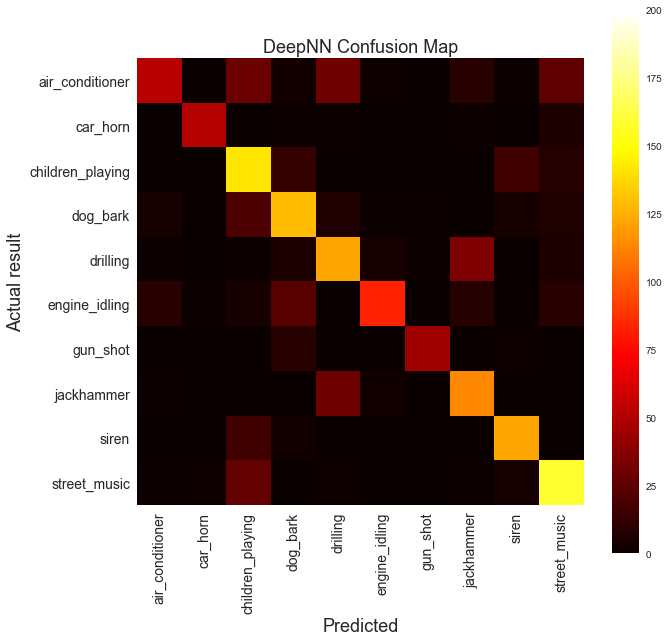

In [38]:
matrix = confusion(test_batch, test_preds['DeepNN'])

plt.figure(figsize=[10,10])
plt.imshow(matrix, cmap='hot', interpolation='nearest',  vmin=0, vmax=200)
plt.colorbar()
plt.title('DeepNN Confusion Map', fontsize=18)
plt.ylabel('Actual result', fontsize=18)
plt.xlabel('Predicted', fontsize=18)
plt.grid(b=False)
plt.yticks(range(10), le.classes_, fontsize=14)
plt.xticks(range(10), le.classes_, fontsize=14, rotation='vertical')
plt.show()

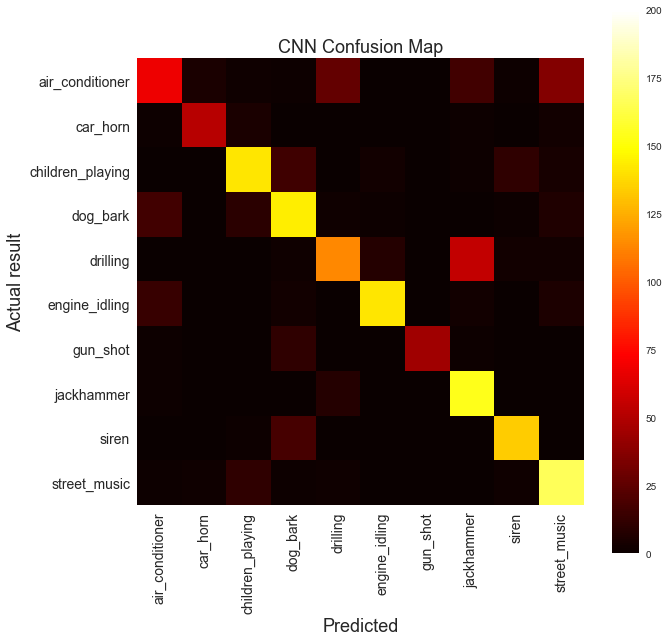

In [39]:
matrix = confusion(test_batch, test_preds['CNN'])

fig = plt.figure(figsize=[10,10])
plt.imshow(matrix, cmap='hot', interpolation='none', vmin=0, vmax=200)
plt.colorbar()
plt.title('CNN Confusion Map', fontsize=18)
plt.ylabel('Actual result', fontsize=18)
plt.xlabel('Predicted', fontsize=18)
plt.grid(b=False)
plt.yticks(range(10), le.classes_, fontsize=14)
plt.xticks(range(10), le.classes_, fontsize=14, rotation='vertical')
plt.show()